In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
import sys

sys.path.append('..')

import torch
from transformers import AutoTokenizer
from termcolor import colored
from tqdm import tqdm
from models.modeling_observation import LlamaForCausalLM
from models.cache_utils import FlashSimpleCacheDist
import math
from utils.sampling import norm_logits, sample
from utils.misc import spec_stream
import socket
host = socket.gethostname()
import argparse

######## model initialization ########
target = LlamaForCausalLM.from_pretrained("NousResearch/Yarn-Llama-2-7b-128k", torch_dtype=torch.float16, device_map="auto")

target = target.eval()
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Yarn-Llama-2-7b-128k", use_fast=True, legacy=False)
from data.dataset import get_dataset
tokenized_prompts = get_dataset(dataset_name='benchmark', tokenizer=tokenizer, datalen=32768)

######## sampling parameters ########

top_k = -1
top_p = 0.9
temperature = 0.6

prefill = 32768
gen_len = 256

####### cache init #######
cache = FlashSimpleCacheDist(target, prefill+gen_len+16)
cache.print_status()
print(colored(f"tokenized_prompts length: {len(tokenized_prompts)}", "green"))

######## Warm up for baseline ########
with torch.inference_mode():
    for input_ids in tqdm(tokenized_prompts, desc="Getting..."):
        cache.reset()
        cache.print_status()
        input_ids = input_ids.to(target.device)[:,:prefill]

        iter_prefill = math.ceil(input_ids.shape[1] / 100)
        for i in range(iter_prefill):
            logits = target(
                input_ids=input_ids[:, i*100:(i+1)*100],
                kv_cache=cache,
                graph_cache=None,
            ).logits
        cache.print_status()

        next_token = sample(norm_logits(logits[:,-1,:], temperature=temperature ,top_k=top_k, top_p=top_p))

        n = 0
        while n < gen_len:
            logits = target(input_ids=next_token, kv_cache=cache).logits
            # print(next_token)
            next_token = sample(norm_logits(logits[:,-1,:], temperature=temperature ,top_k=top_k, top_p=top_p))
            n += 1
            spec_stream(next_token[0], tokenizer, 'cyan')

        cache.print_status()
        print(colored(f"{'='*80}", "red"))


>>>> Flash Attention installed
>>>> Flash RoPE installed


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Cached Size: 0 | Max Budget: 33040
tokenized_prompts length: 1


Getting...:   0%|          | 0/1 [00:00<?, ?it/s]

Cached Size: 0 | Max Budget: 33040
Cached Size: 32768 | Max Budget: 33040
of them . Mr . West on says , " He was born 
 in the county of York , in the year  1 7 1 2 , and was educated at the 
 Univers ity of Cambridge . In  1 7 3 7 he was made Master of the Gram mar 
 Sch ool of W ake field . In  1 7 4 5 he was elected a Fellow of the Royal 
 So ci ety . In  1 7 5 6 he was made R ector of the parish of W ake field , where he 
 d ied in  1 7 6 2 ." His " G ard ener ' s Kal endar ," first published in  1 7 6 0 , and 
 which was continued to the year  1 7 6 8 , and which , in  1 7 7 3 , was 
 cont in ued to  1 7 7 5 , and again in  1 7 7 8 to  1 7 7 9 , and again in  1 7 8 0 to 
 1 7 8 2 , is one of the most interesting and useful works of the kind that 
 has appeared . It is very neat ly printed , and is illustrated with very 
 ne at co pper - plates . It contains much interesting information , and 
 contains , also , a list of the most valuable books on garden ing 

Getting...: 100%|██████████| 1/1 [00:32<00:00, 32.04s/it]

Cached Size: 33024 | Max Budget: 33040


In [2]:
len(cache.scores)

32

In [ ]:
# layer, 256, 32, datalen

In [42]:
topk_values, _ = torch.topk(cache.scores[1][token], k=512, dim=-1)

In [44]:
topk_values.shape

torch.Size([32, 512])

In [45]:
cache.scores[1][token].sum(dim=-1).shape

torch.Size([32])

In [47]:
(topk_values.sum(dim=-1) / cache.scores[1][token].sum(dim=-1))

tensor([0.2681, 0.4324, 0.9463, 0.3845, 0.2844, 0.3740, 0.7715, 0.5894, 0.1648,
        0.6001, 0.1676, 0.1201, 0.8086, 0.2625, 0.3367, 0.4211, 0.8018, 0.4011,
        0.6470, 0.5498, 0.2131, 0.7656, 0.9917, 0.6792, 0.3652, 0.8345, 0.2571,
        0.7095, 0.3015, 0.4495, 0.7637, 0.5449], device='cuda:0',
       dtype=torch.float16)

In [ ]:

token_list = []
for token in range(256):
    topk_values, _ = torch.topk(cache.scores[1][token], k=512, dim=-1) # torch.Size([32, top])
    token_list.append((topk_values.sum(dim=-1) / cache.scores[1][token].sum(dim=-1)).item())

In [54]:
def sparsity(scores, tops = [1,8,16,32,64,128,256, 512, 1024, 2048,4096, 8192, 16384]):
    ret = {}
    for layer in tqdm(range(len(scores))):
        for top in tops:
            token_list = []
            for token in range(256):
                topk_values, _ = torch.topk(scores[layer][token], k=top, dim=-1)
                token_list.append(topk_values.sum(dim=-1) / scores[layer][token].sum(dim=-1))
            
            tmp = sum(token_list) / len(token_list)
            ret[f"layer-{layer}-top-{top}"] = tmp.cpu().numpy()
    
    return ret

In [55]:
sparsity_dict = sparsity(cache.scores)

100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


In [56]:
# write to csv
import csv

with open('sparsity.csv', 'a') as f:
    for key in sparsity_dict.keys():
        f.write("%s,%s\n"%(key,sparsity_dict[key]))

In [ ]:
sparsity_dict

In [74]:
sparsity_dict

layer = 4
token = 0
head = 1
top = 1
print(sparsity_dict[f"layer-{layer}"][f"token-{token}"][f"head-{head}"][f"top-{top}"])

0.98779296875


In [8]:
cache.chunks['layer-0-chunk=8'].shape

torch.Size([32, 4096])

In [20]:
layer=10
token=0
head=15
top=4096

topk_values, topk_idx = torch.topk(cache.scores[layer][token][head][:32768], k=top, dim=-1)

token = 6

topk_values_100, topk_idx_100 = torch.topk(cache.scores[layer][token][head][:32768], k=top, dim=-1)

coverage = torch.isin(topk_idx_100 // 8, topk_idx // 8).float().mean()
print("coverage", coverage)

selected_scores = topk_values_100[torch.isin(topk_idx_100 // 8, topk_idx // 8)]
score_percentage = selected_scores.sum() / topk_values_100.sum()
print("score_percentage", score_percentage)

coverage tensor(0.8752, device='cuda:1')
score_percentage tensor(0.9746, device='cuda:1', dtype=torch.float16)


In [9]:
cache.chunks[layer][head].shape

torch.Size([4096])

In [22]:
_, topk_idx_rest = torch.topk(cache.chunks[layer][head][1:], k=512-1, dim=-1) # (bsz, 32, select_sets) --> (bsz, select_sets, 32)
topk_idx_rest += 1
topk_idx_first = torch.zeros((1), device=topk_idx_rest.device, dtype=topk_idx_rest.dtype)
topk_idx = torch.cat([topk_idx_first, topk_idx_rest], dim=-1)  # (bsz, 32, select_sets)

In [ ]:
topk_idx

In [7]:
topk_idx.shape

torch.Size([32, 4096])

In [9]:
torch.gather(cache.scores[6][10][:,:prefill], 1, topk_idx).

torch.Size([32, 4096])

In [6]:
cache.scores[6][10][:,:prefill].shape

torch.Size([32, 32768])

In [17]:
layer=6
token=100
top=4096
prefill= 32768

_, topk_idx = torch.topk(cache.scores[layer][0][:,:prefill], k=top, dim=-1)

selected_scores = torch.gather(cache.scores[layer][token][:,:prefill], 1, topk_idx)
score_percentage = selected_scores.sum(dim=-1) / cache.scores[layer][token][:,:prefill].sum(dim=-1)
score_percentage

tensor([0.9707, 0.9873, 0.9551, 0.8320, 0.9697, 0.9712, 0.8940, 0.9888, 0.9233,
        0.9106, 0.9736, 0.9917, 0.8188, 0.9639, 0.9702, 0.9565, 0.6562, 0.9312,
        0.9912, 0.8584, 0.9238, 0.8208, 0.9644, 0.9692, 0.9673, 0.4028, 0.9902,
        0.9521, 0.9888, 0.9888, 0.9258, 0.9917], device='cuda:0',
       dtype=torch.float16)

In [ ]:
_, topk_idx = torch.topk(cache.scores[layer][token][:,:32768], k=top, dim=-1)

selected_scores = cache.scores[layer][token][:,:prefill][topk_idx]
score_percentage = selected_scores.sum() / cache.scores[layer][token][:,:prefill].sum(dim=-1)
score_percentage_list.append(score_percentage.item())

whole = (selected_scores.sum()+cache.scores[layer][token][head][prefill:].sum()) / cache.scores[layer][token][head].sum()
whole_score_per.append(whole.item())

local = cache.scores[layer][token][head][prefill:].sum()/cache.scores[layer][token][head].sum()
local_info_per.append(local.item())

In [34]:
token=100
top=4096
layer=0

_, topk_idx = torch.topk(cache.scores[layer][0][:,:prefill], k=top, dim=-1)
selected_scores = torch.gather(cache.scores[layer][token][:,:prefill], 1, topk_idx)
restored_long = (selected_scores.sum(dim=-1) / cache.scores[layer][token][:,:prefill].sum(dim=-1)).mean()
restored_long

tensor(0.3328, device='cuda:0', dtype=torch.float16)

In [57]:

def locality(scores, prefill, gen_len):
    long_info = {}
    for layer in range(32):
        long_info[layer] = []
        for token in range(gen_len):
            _, topk_idx = torch.topk(scores[layer][0][:,:prefill], k=top, dim=-1)
            selected_scores = torch.gather(scores[layer][token][:,:prefill], 1, topk_idx)
            restored_long = (selected_scores.sum(dim=-1) / scores[layer][token][:,:prefill].sum(dim=-1)).mean()
            long_info[layer].append(restored_long.item())
    return long_info

long_info = locality(cache.scores)

# save to csv
import csv
path = 'locality.csv'
with open(path, 'a') as f:
    for key in long_info.keys():
        f.write("%s,%s\n"%(key,long_info[key]))

In [2]:
import figures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns


plt.rcParams["font.family"] = "Times New Roman"
sns.set_theme()
# color1='#8da0cb'
# color2='#fc8d62'
# color3='#66c2a5'
# color4='brown'

color1 = '#66c2a5'
color2 = '#fc8d62'
color3 = '#8da0cb'
color4 = '#e78ac3'
color5 = '#a6d854'

/tmp/ipykernel_3980502/3168674943.py:2: DtypeWarning: Columns (37,39,40,41,42,43,45,57,96,145,146,176,269,279,284,290,293,306,344,356,358,359,360,361,366,368,371,407,408,422,444,461,481,499,500,519,557,595,633,639,709,747,785,823,861,899,905,937,975,1013) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('locality.csv', header=None)


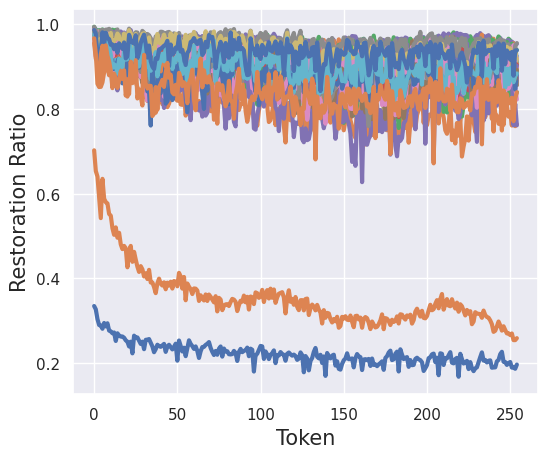

In [135]:
plt.figure(figsize=(6, 5))
df = pd.read_csv('locality.csv', header=None)

# plot each row as a line

for i in range(32):
    line = df.iloc[i]
    y = line[1:256]
    x = range(len(y))
    plt.plot(x, y, label=f'layer-{i}', linewidth=3)
plt.xlabel('Token', fontsize=15)
plt.ylabel('Restoration Ratio', fontsize=15)
plt.savefig('locality.png', dpi=300, bbox_inches='tight')
# plt.legend()

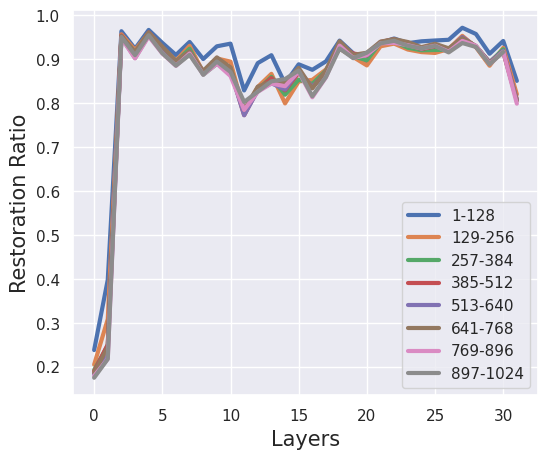

In [136]:
plt.figure(figsize=(6, 5))
T = 8
step = 1024/T
for i in range(T):
    y_list = []
    start = int(i*step+1)
    end = int((i+1)*step)
    for j in range(32):
        y = np.array(df.iloc[j][start:end], dtype=np.float32).mean()
        y_list.append(y)
    x = range(32)
    plt.plot(x, y_list, label=f'{start}-{end}', linewidth=3)

plt.xlabel('Layers', fontsize=15)
plt.ylabel('Restoration Ratio', fontsize=15)
plt.legend()
plt.savefig('locality_layer.png', dpi=300, bbox_inches='tight')

In [55]:
df = pd.read_csv('sparsity.csv', header=None)
df

,0,1
0,layer-0-top-1,0.06104 0.05078 0.0003338 0.01743 0.0069...
1,0.00148 0.0833 0.001511 0.001993 0.003...,NaN
2,0.02086 0.01979 0.003712 0.0005503 0.026...,NaN
3,0.00042 0.0004554 0.00248 0.003431 0.055...,NaN
4,0.002008 0.0226 0.006336 0.0001558,NaN
...,...,...
1661,0.9995 0.9995,NaN
1662,layer-31-top-16384,0.9995 0.9995 0.9995 0.9995 1. 0.9995 0.99...
1663,0.992 0.999 0.9995 0.9995 0.9985 0.9985 0.9...,NaN
1664,0.9995 0.999 0.998 0.9995 0.9985 0.9995 0.9...,NaN


In [105]:
import pandas as pd


file_path = 'sparsity.csv'
with open(file_path, 'r') as file:
    data = file.read()
entries = data.split('layer-')
entries = [f'layer-{entry}' for entry in entries if entry]

df = pd.DataFrame()

for entry in entries:
    entry_df = pd.DataFrame([entry.split(',')])
    df = pd.concat([df, entry_df], ignore_index=True)

layer_dic = {}
for i in range(32):
    j = 0
    layer_dic[f'layer-{i}'] = {}
    for top in [1,8,16,32,64,128,256, 512, 1024, 2048,4096, 8192, 16384]:
        # print(f'layer-{i}', f'top-{top}')
        tmp = df.iloc[13*i+j][1]
        tmp = tmp.replace('\n','')
        tmp = tmp.split(' ')
        ret = []
        for k in range(len(tmp)):
            if tmp[k] != '' and tmp[k] != '.' and len(tmp[k]) !=0:
                try :
                    ret.append(float(tmp[k]))
                except:
                    pass
        assert len(ret) == 32
        layer_dic[f'layer-{i}'][f'top-{top}'] = ret
        j += 1

Text(0.5, 1.0, 'Sparsity of top-16 tokens')

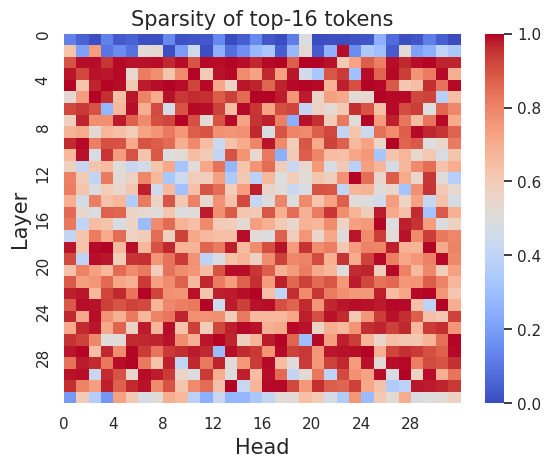

In [126]:
top = 16

import seaborn
import matplotlib.pyplot as plt
import numpy as np

# plot heatmap

data = np.array([layer_dic[f'layer-{i}'][f'top-{top}'] for i in range(32)])
fig, ax = plt.subplots()
seaborn.heatmap(data, ax=ax, cmap='coolwarm', vmin=0, vmax=1)
ticks = np.arange(0, data.shape[0], 4)
tick_labels = [str(i) for i in ticks]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Head', fontsize=15)
ax.set_ylabel('Layer', fontsize=15)
ax.set_title(f'Sparsity of top-{top} tokens', fontsize=15)

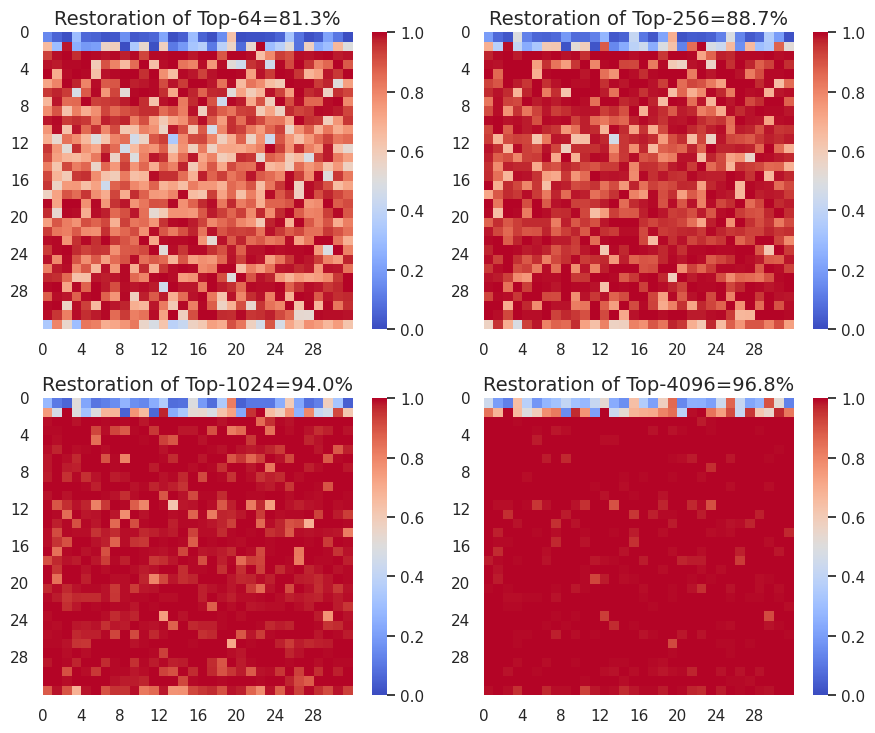

In [147]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

top_values = [64, 256, 1024, 4096]
fig, axs = plt.subplots(2, 2, figsize=(9, 7.5))

# 遍历所有子图和对应的top值
for ax, top in zip(axs.flat, top_values):
    data = np.array([layer_dic[f'layer-{i}'][f'top-{top}'] for i in range(32)])
    sns.heatmap(data, ax=ax, cmap='coolwarm', vmin=0, vmax=1)
    ticks = np.arange(0, data.shape[0], 4)
    tick_labels = [str(i) for i in ticks]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    # ax.set_xlabel('Head', fontsize=12)
    # ax.set_ylabel('Layer', fontsize=12)
    ax.set_title(f'Restoration of Top-{top}={round(data.mean()*100,1)}%', fontsize=14)

plt.tight_layout()
# plt.show()
plt.savefig('sparsity.png', dpi=300, bbox_inches='tight')

In [106]:
len(layer_dic[f'layer-{0}'][f'top-{8}'])

32

In [77]:
df.iloc[0][1]

'0.06104   0.05078   0.0003338 0.01743   0.006916  0.01222   0.001127\n 0.00148   0.0833    0.001511  0.001993  0.003902  0.0322    0.0001783\n 0.02086   0.01979   0.003712  0.0005503 0.02649   0.0739    0.0008135\n 0.00042   0.0004554 0.00248   0.003431  0.0558    0.04718   0.000444\n 0.002008  0.0226    0.006336  0.0001558\n'

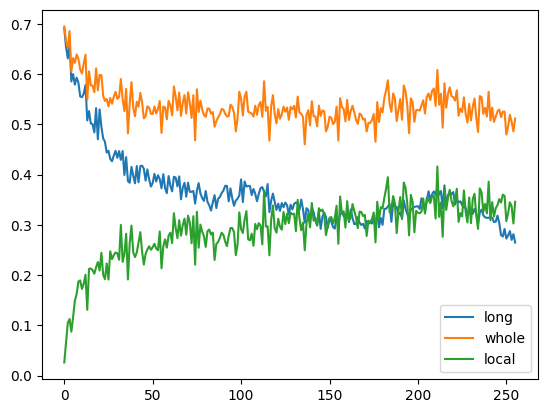

In [38]:
layer=1
prefill = 32768

long_context_info = []
whole_info = []
local_info = []
restored_info = []
for token in range(256):
    _, topk_idx = torch.topk(cache.scores[layer][0][:,:prefill], k=top, dim=-1)
    selected_scores = torch.gather(cache.scores[layer][token][:,:prefill], 1, topk_idx)
    restored_long = selected_scores.sum(dim=-1) / cache.scores[layer][token][:,:prefill].sum(dim=-1)
    restored_info.append(restored_long.mean().item())


    for head in range(32):
        _, topk_idx_rest = torch.topk(cache.chunks[layer][head][1:], k=512-1, dim=-1) # (32, select_sets) --> (select_sets, 32)
        topk_idx_rest += 1
        topk_idx_first = torch.zeros((1), device=topk_idx_rest.device, dtype=topk_idx_rest.dtype)
        topk_idx = torch.cat([topk_idx_first, topk_idx_rest], dim=-1)  # (32, select_sets)

        expanded_indices = torch.cat([torch.arange(start=idx*8, end=(idx+1)*8) for idx in topk_idx])
        selected_scores = cache.scores[layer][token][head][:prefill][expanded_indices]
        score_percentage = selected_scores.sum() / cache.scores[layer][token][head][:prefill].sum()
        score_percentage_list.append(score_percentage.item())
        
        whole = (selected_scores.sum()+cache.scores[layer][token][head][prefill:].sum()) / cache.scores[layer][token][head].sum()
        whole_score_per.append(whole.item())
        
        local = cache.scores[layer][token][head][prefill:].sum()/cache.scores[layer][token][head].sum()
        local_info_per.append(local.item())

    long_context_info.append(sum(score_percentage_list) / len(score_percentage_list))
    whole_info.append(sum(whole_score_per) / len(whole_score_per))
    local_info.append(sum(local_info_per) / len(local_info_per))

from matplotlib import pyplot as plt
plt.plot(long_context_info, label = "long")
plt.plot(whole_info, label = "whole")
plt.plot(local_info, label = "local")
plt.legend()

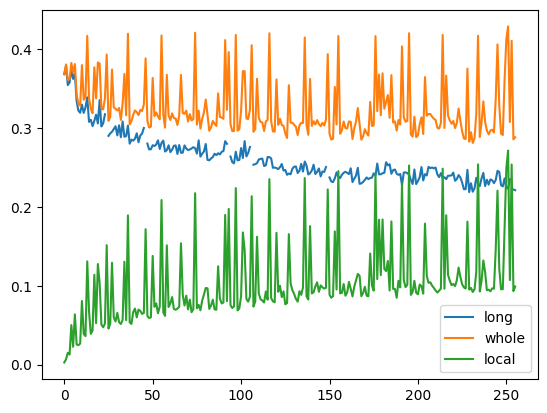

In [35]:
layer=0
prefill = 32768

long_context_info = []
whole_info = []
local_info = []

for token in range(256):
    score_percentage_list = []
    whole_score_per = []
    local_info_per = []

    for head in range(32):
        _, topk_idx_rest = torch.topk(cache.chunks[layer][head][1:], k=512-1, dim=-1) # (32, select_sets) --> (select_sets, 32)
        topk_idx_rest += 1
        topk_idx_first = torch.zeros((1), device=topk_idx_rest.device, dtype=topk_idx_rest.dtype)
        topk_idx = torch.cat([topk_idx_first, topk_idx_rest], dim=-1)  # (32, select_sets)

        expanded_indices = torch.cat([torch.arange(start=idx*8, end=(idx+1)*8) for idx in topk_idx])
        selected_scores = cache.scores[layer][token][head][:prefill][expanded_indices]
        score_percentage = selected_scores.sum() / cache.scores[layer][token][head][:prefill].sum()
        score_percentage_list.append(score_percentage.item())
        
        whole = (selected_scores.sum()+cache.scores[layer][token][head][prefill:].sum()) / cache.scores[layer][token][head].sum()
        whole_score_per.append(whole.item())
        
        local = cache.scores[layer][token][head][prefill:].sum()/cache.scores[layer][token][head].sum()
        local_info_per.append(local.item())

    long_context_info.append(sum(score_percentage_list) / len(score_percentage_list))
    whole_info.append(sum(whole_score_per) / len(whole_score_per))
    local_info.append(sum(local_info_per) / len(local_info_per))

from matplotlib import pyplot as plt
plt.plot(long_context_info, label = "long")
plt.plot(whole_info, label = "whole")
plt.plot(local_info, label = "local")
plt.legend()

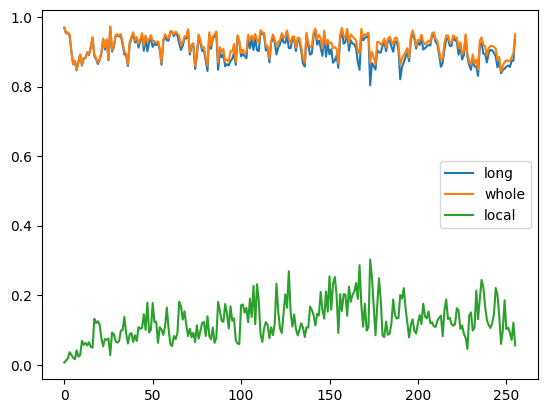

In [36]:
layer=6
prefill = 32768

long_context_info = []
whole_info = []
local_info = []
restored_info = []
for token in range(256):
    score_percentage_list = []
    whole_score_per = []
    local_info_per = []
    restored_per = []

    for head in range(32):
        _, topk_idx_rest = torch.topk(cache.chunks[layer][head][1:], k=512-1, dim=-1) # (32, select_sets) --> (select_sets, 32)
        topk_idx_rest += 1
        topk_idx_first = torch.zeros((1), device=topk_idx_rest.device, dtype=topk_idx_rest.dtype)
        topk_idx = torch.cat([topk_idx_first, topk_idx_rest], dim=-1)  # (32, select_sets)

        expanded_indices = torch.cat([torch.arange(start=idx*8, end=(idx+1)*8) for idx in topk_idx])
        selected_scores = cache.scores[layer][token][head][:prefill][expanded_indices]
        score_percentage = selected_scores.sum() / cache.scores[layer][token][head][:prefill].sum()
        score_percentage_list.append(score_percentage.item())
        
        whole = (selected_scores.sum()+cache.scores[layer][token][head][prefill:].sum()) / cache.scores[layer][token][head].sum()
        whole_score_per.append(whole.item())
        
        local = cache.scores[layer][token][head][prefill:].sum()/cache.scores[layer][token][head].sum()
        local_info_per.append(local.item())

    long_context_info.append(sum(score_percentage_list) / len(score_percentage_list))
    whole_info.append(sum(whole_score_per) / len(whole_score_per))
    local_info.append(sum(local_info_per) / len(local_info_per))

from matplotlib import pyplot as plt
plt.plot(long_context_info, label = "long")
plt.plot(whole_info, label = "whole")
plt.plot(local_info, label = "local")
plt.legend()

In [ ]:
prefill = 32768

local_info_all = {}
long_context_info_all = {}
whole_info_all = {}

for layer in range(32):
    long_context_info = []
    whole_info = []
    local_info = []
    restored_info = []
    for token in range(256):
        score_percentage_list = []
        whole_score_per = []
        local_info_per = []
        restored_per = []

        for head in range(32):
            _, topk_idx_rest = torch.topk(cache.chunks[layer][head][1:], k=512-1, dim=-1) # (32, select_sets) --> (select_sets, 32)
            topk_idx_rest += 1
            topk_idx_first = torch.zeros((1), device=topk_idx_rest.device, dtype=topk_idx_rest.dtype)
            topk_idx = torch.cat([topk_idx_first, topk_idx_rest], dim=-1)  # (32, select_sets)

            expanded_indices = torch.cat([torch.arange(start=idx*8, end=(idx+1)*8) for idx in topk_idx])
            selected_scores = cache.scores[layer][token][head][:prefill][expanded_indices]
            score_percentage = selected_scores.sum() / cache.scores[layer][token][head][:prefill].sum()
            score_percentage_list.append(score_percentage.item())
            
            whole = (selected_scores.sum()+cache.scores[layer][token][head][prefill:].sum()) / cache.scores[layer][token][head].sum()
            whole_score_per.append(whole.item())
            
            local = cache.scores[layer][token][head][prefill:].sum()/cache.scores[layer][token][head].sum()
            local_info_per.append(local.item())

        long_context_info.append(sum(score_percentage_list) / len(score_percentage_list))
        whole_info.append(sum(whole_score_per) / len(whole_score_per))
        local_info.append(sum(local_info_per) / len(local_info_per))

    long_context_info_all[layer] = long_context_info
    whole_info_all[layer] = whole_info
    local_info_all[layer] = local_info

In [ ]:
topk_values, topk_idx = torch.topk(cache.scores[layer][token][head][:32768], k=top, dim=-1)

In [43]:
cache.scores[layer][token][head][prefill:].sum()

tensor(0.3860, device='cuda:0', dtype=torch.float16)

In [4]:
cache.scores[layer][token][head][:32768].sum()

tensor(0.7300, device='cuda:1', dtype=torch.float16)

In [36]:
expanded_indices = torch.cat([torch.arange(start=idx*8, end=(idx+1)*8) for idx in topk_idx])

In [ ]:
torch.topk(cache.scores[layer][token][head][:32768], k=top, dim=-1)

In [7]:
cache.chunks[layer][head]

tensor([5.2795e-03, 2.4509e-04, 7.3016e-05,  ..., 2.2186e-02, 4.4830e-02,
        2.4368e-02], device='cuda:1', dtype=torch.float16)

In [ ]:
torch.isin(topk_idx_100 // 8, topk_idx // 8)

In [109]:
selected_scores = topk_values_100[torch.isin(topk_idx_100 // 8, topk_idx // 8)]

In [113]:
selected_scores.shape

torch.Size([169])

In [114]:
topk_values_100.shape

torch.Size([256])

In [110]:
score_percentage = selected_scores.sum() / topk_values_100.sum()

In [111]:
score_percentage

tensor(0.9092, device='cuda:1', dtype=torch.float16)

In [ ]:
def locality(scores, cache, prefill=32768, tops=[1,2,4,8,16,32,64,128,256], chunk_size=8):
    ret = {}
    for top in tops:
        ret[f"top-{top}"] = {}
        for layer in range(len(scores)):
            ret[f"top-{top}"][f"layer-{layer}"] = {}
            for head in range(32):
                ret[f"top-{top}"][f"layer-{layer}"][f"head-{head}"] = {}
                select_chunks = scores[f"layer-{layer}-chunk=8"][head][:top]
                for token in range(len(scores[f"layer-{layer}-chunk=8"][head])):
                    ret[f"top-{top}"][f"layer-{layer}"][f"head-{head}"][f"token-{token}"] = {}
                    # 计算 top-k 值和索引
                    topk_values, topk_idx = torch.topk(cache.scores[layer][token][head][:prefill], k=top, dim=-1)
                    # 计算覆盖度
                    coverage = torch.isin(topk_idx // chunk_size, select_chunks).float().mean()
                    # 计算在选定 chunks 中的 score 百分比
                    selected_scores = topk_values[torch.isin(topk_idx // chunk_size, select_chunks)]
                    score_percentage = selected_scores.sum() / topk_values.sum()
                    # 将结果保存到 ret 字典中
                    ret[f"top-{top}"][f"layer-{layer}"][f"head-{head}"][f"token-{token}"]["coverage"] = coverage.item()
                    ret[f"top-{top}"][f"layer-{layer}"][f"head-{head}"][f"token-{token}"]["score_percentage"] = score_percentage.item()
    return ret

In [66]:
sparsity_dict['layer-7']['token-0']['head-0']['top-256']

tensor(0.9824, device='cuda:1', dtype=torch.float16)

In [ ]:
def locality(scores, prefill=32768, tops = [1,2,4,8,16,32,64,128,256], chunk_size=8):
    ret = {}
    for top in tops:
        for layer in range(len(scores)):
            for head in range(32):
                select_chunks = scores[f"layer-{layer}-chunk=8"][head][:top]
                for token in range(len(scores[layer])):
                    ret[f"top-{top}"][f"layer-{layer}"][f"head-{head}"][f"token-{token}"] = {}
                    # long context info
                    topk_values, topk_idx = torch.topk(cache.scores[layer][token][head][:prefill], k=top, dim=-1)
                    coverage = torch.isin(topk_idx // chunk_size, select_chunks).float().mean()
                    # coverage
                    ret[f"top-{top}"][f"layer-{layer}"][f"head-{head}"][f"token-{token}"]["coverage"] = coverage

In [3]:
cache.scores.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [18]:
cache.scores[0][1][0].shape

torch.Size([32770])

In [49]:
topk_values, keep_topk = torch.topk(cache.scores[0][0][0], k=5000, dim=-1)

In [51]:
cache.scores[0][1][0].sum()

tensor(1., device='cuda:0', dtype=torch.float16)

In [50]:
topk_values.sum()

tensor(0.5986, device='cuda:0', dtype=torch.float16)

In [10]:
32*256*32*128*1024*2/1024**3

64.0